<a href="https://colab.research.google.com/github/rodrigomeireles/notebooks/blob/main/Crank_Nicolson_traduzido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**negrito**# "The Crank-Nicolson method implemented from scratch in Python"
(https://georg.io/2013/12/03/Crank_Nicolson)
> "In this article we implement the well-known finite difference method Crank-Nicolson in Python."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, numpy, numerical analysis, partial differential equations]

Tradução por Rodrigo Meireles

# O Método de Crank-Nicolson

O [método de Crank-Nicolson](https://pt.wikipedia.org/wiki/M%C3%A9todo_de_Crank%E2%80%93Nicolson) é um método de diferenças finitas bem conhecido para a integração numérica da equação de calor e equações diferenciais parciais relacionadas.

Frequentemente recorremos a um esquema Crank-Nicolson (CN) quando integramos numericamente sistemas de reação-difusão em espaços de uma dimensão

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + f(u),$$

$$\frac{\partial u}{\partial x}\Bigg|_{x = 0, L} = 0,$$

onde $u$ é nossa variável de concentração, $x$ é a variável do espaço, $D$ é o coeficiente de difusão de $u$, $f$ é o termo reacionário,
e $L$ é o comprimento do espaço unidimensional.

Note que usamos a [condição de contorno de Neumann](https://pt.wikipedia.org/wiki/Condi%C3%A7%C3%A3o_de_contorno_de_Neumann) e especificamos que a solução
$u$ tem a derivada nula no contorno, efetivamente proibindo a saída ou entrada de material nas fronteiras (condições de contorno sem fluxo).

## Métodos de Diferenças Finitas

Muitos tutoriais e livros fantásticos foram escritos sobre o método de diferenças finitas, por exemplo o livro gratuito escrito por
[Lloyd Trefethen](http://people.maths.ox.ac.uk/trefethen/pdetext.html).

Aqui descrevemos alguns aspectos básicos do método de diferenças finitas.

A equação de reação-difusão acima descreve a evolução no tempo da variável $u(x,t)$ em uma dimensão do espaço ($u$ é a concentração em uma linha).
Se soubéssemos a expressão analítica para $u(x,t)$ então poderíamos desenhar o gráfico de $u$ em um sistema de coordenadas bidimensional com eixos $t$ e $x$.

Para aproximar $u(x,t)$ numericamente nós discretizamos esse sistema de coordenadas bidimensional resultando, no caso mais simples, em uma grade cartesiana [grade cartesiana](https://pt.wikipedia.org/wiki/Grade_cartesiana) bidimensional.
Esta figura é comumente empregada quando construímos métodos de diferenças finitas, veja por exemplo a 
[Figura 3.2.1 de Trefethen](http://people.maths.ox.ac.uk/trefethen/3all.pdf).

Vamos discretizar tempo e espaço da seguinte maneira:

$$t_n = n \Delta t,~ n = 0, \ldots, N-1,$$

$$x_j = j \Delta x,~ j = 0, \ldots, J-1,$$

onde $N$ e $J$ são, respectivamente, o número de pontos no espaço e tempo na nossa grade.
$\Delta t$ e $\Delta x$ são, respectivamente, o passo no tempo e o passo no espaço e definidos como a seguir:

$$\Delta t = T / N,$$

$$\Delta x = L / J,$$

onde $T$ é o ponto no tempo até onde integraremos $u$ numericamente.

Nosso objetivo final é construirmos um método numéricos que nos permita aproximarmos à solução analítica $u(x,t)$
razoavelmente bem nesses pontos da grade.

Isto é, queremos construir um método que calcule os valores $U(j \Delta x, n \Delta t)$ (note: $U$ maiúsculo) de maneira que

$$U(j \Delta x, n \Delta t) \approx u(j \Delta x, n \Delta t)$$

Escreveremos $U_j^n = U(j \Delta x, n \Delta t)$ e $(j,n)$ para nos referir aos pontos da grade $(j \Delta x, n \Delta t)$.

## O Estêncil de Crank-Nicolson

Baseados na grade bidimensional que construímos, aproximamos os operadores do nosso modelo de reação-difusão.

Por exemplo, para aproximar a derivada no tempo do lado esquerdo da equação no ponto $(j,n)$ nós usamos os valores de $U$ em dois pontos específicos da grade:

$$\frac{\partial u}{\partial t}\Bigg|_{x = j \Delta x, t = n \Delta t} \approx \frac{U_j^{n+1} - U_j^n}{\Delta t}.$$

Podemos pensar nesse esquema como um estêncil que sobrepomos à grade $(x,t)$, este estêncil em específico é comumente conhecido como [diferença posterior](https://pt.wikipedia.org/wiki/Operador_de_diferen%C3%A7a).

A parte espacial do [estêncil de Crank-Nicolson](http://journals.cambridge.org/abstract_S0305004100023197)
\(ou veja a [Tabela 3.2.2 de Trefethen](http://people.maths.ox.ac.uk/trefethen/3all.pdf)\)
para a equação de calor ($u_t = u_{xx}$) aproxima o
[Laplaciano](https://pt.wikipedia.org/wiki/Laplaciano) da nossa equação e toma a seguinte forma

$$\frac{\partial^2 u}{\partial x^2}\Bigg|_{x = j \Delta x, t = n \Delta t} \approx \frac{1}{2 \Delta x^2} \left( U_{j+1}^n - 2 U_j^n + U_{j-1}^n + U_{j+1}^{n+1} - 2 U_j^{n+1} + U_{j-1}^{n+1}\right).$$

Para aproximar $f(u(j \Delta x, n \Delta t))$ simplesmente escrevemos $f(U_j^n)$.

Estas aproximações definem o estêncil para o nosso método numérico como visto na [Wikipedia](https://pt.wikipedia.org/wiki/M%C3%A9todo_de_Crank%E2%80%93Nicolson).

Aplicando o estêncil ao ponto da grade $(j,n)$ nos dá a seguinte aproximação para a nossa equação de reação-difusão:

$$\frac{U_j^{n+1} - U_j^n}{\Delta t} = \frac{D}{2 \Delta x^2} \left( U_{j+1}^n - 2 U_j^n + U_{j-1}^n + U_{j+1}^{n+1} - 2 U_j^{n+1} + U_{j-1}^{n+1}\right) + f(U_j^n).$$

## Reordenando o Estêncil em um Sistema Linear

Vamos definir $\sigma = \frac{D \Delta t}{2 \Delta x^2}$ e reordenar a aproximação acima da nossa equação de reação-difusão:

$$-\sigma U_{j-1}^{n+1} + (1+2\sigma) U_j^{n+1} -\sigma U_{j+1}^{n+1} = \sigma U_{j-1}^n + (1-2\sigma) U_j^n + \sigma U_{j+1}^n + \Delta t f(U_j^n).$$

Esta equação faz sentidos para índices espaciais $j = 1,\ldots,J-2$ mas não faz sentido para os índices $j=0$ and $j=J-1$ (nas fronteiras):

$$j=0:~-\sigma U_{-1}^{n+1} + (1+2\sigma) U_0^{n+1} -\sigma U_{1}^{n+1} = \sigma U_{-1}^n + (1-2\sigma) U_0^n + \sigma U_{1}^n + \Delta t f(U_0^n),$$

$$j=J-1:~-\sigma U_{J-2}^{n+1} + (1+2\sigma) U_{J-1}^{n+1} -\sigma U_{J}^{n+1} = \sigma U_{J-2}^n + (1-2\sigma) U_{J-1}^n + \sigma U_{J}^n + \Delta t f(U_{J-1}^n).$$

O problema aqui é que os valores $U_{-1}^n$ and $U_J^n$ estão fora da grade.

No entanto, utilizando as condições de contorno de Neumann, podemos descobrir quais valores a fronteira deveria ter.
Vamos discretizar nossa fronteira em $j=0$ com a
[diferença anterior](http://en.wikipedia.org/wiki/Finite_difference#Forward.2C_backward.2C_and_central_differences) e em $j=J-1$ com a
[diferença posterior](http://en.wikipedia.org/wiki/Finite_difference#Forward.2C_backward.2C_and_central_differences):

$$\frac{U_1^n - U_0^n}{\Delta x} = 0,$$

$$\frac{U_J^n - U_{J-1}^n}{\Delta x} = 0.$$
Estas duas equações deixam claro que precisamos retificar nossa aproximação numérica acima para
$j=0$ com as identidades $U_0^n = U_1^n$ and $U_0^{n+1} = U_1^{n+1}$, e para $j=J-1$ com as identidades $U_{J-1}^n = U_J^n$ and $U_{J-1}^{n+1} = U_J^{n+1}$.

Vamos reinterpretar nossa aproximação numérica da concentração linear de $u$ em um ponto fixo como um vetor $\mathbf{U}^n$:

$$\mathbf{U}^n = 
\begin{bmatrix} U_0^n \\ \vdots \\ U_{J-1}^n \end{bmatrix}.$$

Usando essa notação podemos escrever nossa aproximação acima para um ponto fixo do tempo, $t = n \Delta t$, de maneira compacta como um sistema linear:

$$
\begin{bmatrix}
1+\sigma & -\sigma & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0\\
-\sigma & 1+2\sigma & -\sigma & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & -\sigma & 1+2\sigma & -\sigma & \cdots & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \ddots & \ddots & \ddots & \ddots & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -\sigma & 1+2\sigma & -\sigma \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -\sigma & 1+\sigma
\end{bmatrix}
\begin{bmatrix}
U_0^{n+1} \\
U_1^{n+1} \\
U_2^{n+1} \\
\vdots \\
U_{J-2}^{n+1} \\
U_{J-1}^{n+1}
\end{bmatrix} =
\begin{bmatrix}
1-\sigma & \sigma & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0\\
\sigma & 1-2\sigma & \sigma & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & \sigma & 1-2\sigma & \sigma & \cdots & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \ddots & \ddots & \ddots & \ddots & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma & 1-2\sigma & \sigma \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma & 1-\sigma
\end{bmatrix}
\begin{bmatrix}
U_0^{n} \\
U_1^{n} \\
U_2^{n} \\
\vdots \\
U_{J-2}^{n} \\
U_{J-1}^{n}
\end{bmatrix} +
\begin{bmatrix}
\Delta t f(U_0^n) \\
\Delta t f(U_1^n) \\
\Delta t f(U_2^n) \\
\vdots \\
\Delta t f(U_{J-2}^n) \\
\Delta t f(U_{J-1}^n)
\end{bmatrix}.
$$

Note que como nossa integração numérica começa com uma condição inicial bem definida em $n=0$, $\mathbf{U}^0$, o vetor $\mathbf{U}^{n+1}$ do lado esquerdo é a única variável indeterminada nesse sistema de equações lineares.

Portanto para integrar numericamente nosso sistema de reação-difusão do ponto temporal $n$ até $n+1$ precisamos resolver numericamente para o vetor $\mathbf{U}^{n+1}$.

Vamos chamar a matriz do lado esquerdo $A$ e a do lado direito $B$,
o vetor do lado direito é $\mathbf{f}^n$.
Usando esta notação podemos escrever o sistema acima como

$$A \mathbf{U}^{n+1} = B \mathbf{U}^n + f^n.$$

Nesta equação linear as matrizes $A$ e $B$ estão definidas pelo nosso problema: precisamos especificar essas matrizes uma vez para o nosso problema e incorporar nossas condições de contorno nelas.
O vetor $\mathbf{f}^n$ é uma função de $\mathbf{U}^n$ e portanto precisa ser recalculado a cada ponto temporal $n$.
Nós também precisamos calcular uma multiplicação entre matriz e vetor para cada ponto temporal, $B \mathbf{U}^n$, e uma soma de vetor com vetor, $B \mathbf{U}^n + f^n$.

A operação numérica mais cara é a inversão da matriz $A$ para encontrar $\mathbf{U}^{n+1}$, no entanto podemos fazer isso apenas uma vez e guardar na memória a inversa de $A$ como $A^{-1}$:

$$\mathbf{U}^{n+1} = A^{-1} \left( B \mathbf{U}^n + f^n \right).$$

## Um Exemplo de Crank-Nicolson em Python

Vamos aplicar o método CN para um sistema bivariado de reação-difusão que foi introduzido por
[Mori *et al.*](http://www.sciencedirect.com/science/article/pii/S0006349508704442):

$$\frac{\partial u}{\partial t} = D_u \frac{\partial^2 u}{\partial x^2} + f(u,v),$$

$$\frac{\partial v}{\partial t} = D_v \frac{\partial^2 v}{\partial x^2} - f(u,v),$$

com condições de contorno de Neumann

$$\frac{\partial u}{\partial x}\Bigg|_{x=0,L} = 0,$$

$$\frac{\partial v}{\partial x}\Bigg|_{x=0,L} = 0.$$

As variáveis deste sistema, $u$ e $v$, respectivamente, representam as concentrações da forma ativa e inativa.
O termo reacionário $f(u,v)$ descreve a troca (ativação e desativação) entre esses dois estados da proteína.
Uma propriedade em particular deste sistema é que o estado inativo tem uma difusidade muito maior que a forma ativa, $D_v \gg D_u$.

Usando o método de CN para integrar este sistema numericamente, precisamos inicializar duas aproximações separadamente

$$A_u \mathbf{U}^{n+1} = B_u \mathbf{U}^n + \mathbf{f}^n,$$

$$A_v \mathbf{V}^{n+1} = B_v \mathbf{V}^n - \mathbf{f}^n,$$

com dois termos $\sigma$ diferentes, $\sigma_u = \frac{D_u \Delta t}{2 \Delta x^2}$ and $\sigma_v = \frac{D_v \Delta t}{2 \Delta x^2}$.

### Importando Pacotes

Para a multiplicação entre matriz e vetor, soma entre vetores e inversão de matrizes  usaremos a biblioteca do [NumPy](http://www.numpy.org/).
Para visualizar as soluções numéricas, usaremos o [pyplot](http://matplotlib.org/api/pyplot_api.html).

In [ ]:
import numpy
from matplotlib import pyplot

Numpy nos permite truncar os valores numéricos das matrizes para melhorar sua visibilidade com [`set_printoptions`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.set_printoptions.html).

In [ ]:
numpy.set_printoptions(precision=3)

### Especificando a Grade

Nosso domínio unidimensional tem tamanho unitário e definimos `J = 100` pontos da grade igualmente espaçados nesse domínio.
Isto divide nosso domínio em `J-1` subintervalos, cada um de tamanho `dx`.

In [ ]:
L = 1.
J = 100
dx = float(L)/float(J-1)
x_grid = numpy.array([j*dx for j in range(J)])

Igualmente, definimos `N = 1000` pontos da grade igualmente espaçados no domínio temporal de tamanho `T = 200`, portanto dividindo nosso domínio temporal em `N-1` intervalos de tamanho `dt`.

In [ ]:
T = 200
N = 1000
dt = float(T)/float(N-1)
t_grid = numpy.array([n*dt for n in range(N)])

### Especificando os Parâmetros do Sistema e o Termo Reacionário

Escolhemos nossos parâmetros baseados no trabalho de
[Mori *et al.*](http://www.sciencedirect.com/science/article/pii/S0006349508704442).

In [ ]:
D_v = float(10.)/float(100.)
D_u = 0.01 * D_v

k0 = 0.067
f = lambda u, v: dt*(v*(k0 + float(u*u)/float(1. + u*u)) - u)
g = lambda u, v: -f(u,v)
 
sigma_u = float(D_u*dt)/float((2.*dx*dx))
sigma_v = float(D_v*dt)/float((2.*dx*dx))

total_protein = 2.26

### Especificando a Condição Inicial

Como discutido em [Mori *et al.*](http://www.sciencedirect.com/science/article/pii/S0006349508704442), podemos esperar observar um comportamento interessante no estado estacionário desse sistema se escolhermos uma condição inicial heterogênea para $u$.

Aqui inicializamos $u$ com heterogeneidade discreta:

In [ ]:
no_high = 10
U =  numpy.array([0.1 for i in range(no_high,J)] + [2. for i in range(0,no_high)])
V = numpy.array([float(total_protein-dx*sum(U))/float(J*dx) for i in range(0,J)])

Note que igualamos o total de proteínas a um certo valor, `total_protein`. A importância disso foi discutida por [Walther *et al.*](http://link.springer.com/article/10.1007%2Fs11538-012-9766-5).

Vamos plotar nossa condição inicial para confirmação:

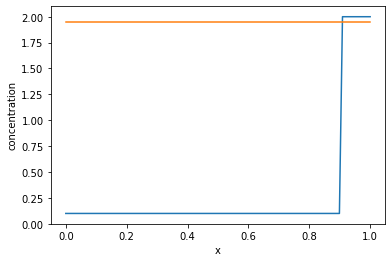

In [ ]:
pyplot.ylim((0., 2.1))
pyplot.xlabel('x'); pyplot.ylabel('concentration')
pyplot.plot(x_grid, U)
pyplot.plot(x_grid, V)
pyplot.show()

A curva azul é a condição inicial para $U$, guardada na variável do Python `U`, a curva verde é a condição inicial para $V$ guardada em `V`.

### Criando Matrizes

As matrizes que precisamos construir são todas tridiagonais, logo fáceis de construir com
[`numpy.diagflat`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.diagflat.html).

In [ ]:
A_u = numpy.diagflat([-sigma_u for i in range(J-1)], -1) +\
      numpy.diagflat([1.+sigma_u]+[1.+2.*sigma_u for i in range(J-2)]+[1.+sigma_u]) +\
      numpy.diagflat([-sigma_u for i in range(J-1)], 1)
        
B_u = numpy.diagflat([sigma_u for i in range(J-1)], -1) +\
      numpy.diagflat([1.-sigma_u]+[1.-2.*sigma_u for i in range(J-2)]+[1.-sigma_u]) +\
      numpy.diagflat([sigma_u for i in range(J-1)], 1)
        
A_v = numpy.diagflat([-sigma_v for i in range(J-1)], -1) +\
      numpy.diagflat([1.+sigma_v]+[1.+2.*sigma_v for i in range(J-2)]+[1.+sigma_v]) +\
      numpy.diagflat([-sigma_v for i in range(J-1)], 1)
        
B_v = numpy.diagflat([sigma_v for i in range(J-1)], -1) +\
      numpy.diagflat([1.-sigma_v]+[1.-2.*sigma_v for i in range(J-2)]+[1.-sigma_v]) +\
      numpy.diagflat([sigma_v for i in range(J-1)], 1)

Para confirmar, é assim que `A_u` se parece:

In [ ]:
print(A_u)

[[ 1.981 -0.981  0.    ...  0.     0.     0.   ]
 [-0.981  2.962 -0.981 ...  0.     0.     0.   ]
 [ 0.    -0.981  2.962 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  2.962 -0.981  0.   ]
 [ 0.     0.     0.    ... -0.981  2.962 -0.981]
 [ 0.     0.     0.    ...  0.    -0.981  1.981]]


### Resolvendo o Sistema Iterativamente

Para avançar o nosso sistema um passo temporal, precisamos fazer uma multiplicação de matriz por vetor seguida de uma soma de vetor com vetor no lado direito da equação.

Para facilitar, reescrevemos nosso termo reacionário para que aceite vetores de concentração $\mathbf{U}^n$ e $\mathbf{V}^n$ como argumentos e retorne um vetor $\mathbf{f}^n$.

Como lembrete, essa é a nossa definição não vetorial de $f$

    f = lambda u, v: v*(k0 + float(u*u)/float(1. + u*u)) - u

In [ ]:
f_vec = lambda U, V: numpy.multiply(dt, numpy.subtract(numpy.multiply(V, 
                     numpy.add(k0, numpy.divide(numpy.multiply(U,U), numpy.add(1., numpy.multiply(U,U))))), U))

Vamos nos certificar que produzimos os mesmos valores que o nosso `f` não vetorial:

In [ ]:
print(f(U[0], V[0]))

0.009961358982745121


In [ ]:
print(f(U[-1], V[-1]))

-0.06238322322322325


In [ ]:
print(f_vec(U, V))

[ 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062]


Levando em conta nosso arrendondamento dos valores exibidos graças a `set_printoptions`, podemos ver que `f` e `f_vec` geram os mesmos valores para nossas condições iniciais em ambos limites do domínio.

Usaremos [`numpy.linalg.solve`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) para resolver nosso sistema linear a cada passo temporal.

Enquanto integramos nosso sistema no tempo, salvaremos tanto `U` quanto `V` a cada passo temporal em `U_record` e `V_record`, respectivamente, para que possamos plotar nossas soluções numéricas no tempo.

In [ ]:
U_record = []
V_record = []

U_record.append(U)
V_record.append(V)

for ti in range(1,N):
    U_new = numpy.linalg.solve(A_u, B_u.dot(U) + f_vec(U,V))
    V_new = numpy.linalg.solve(A_v, B_v.dot(V) - f_vec(U,V))
    
    U = U_new
    V = V_new
    
    U_record.append(U)
    V_record.append(V)

### Plotando a Solução Numérica

Observemos a solução n umérica obtida após `N` espaços temporais.

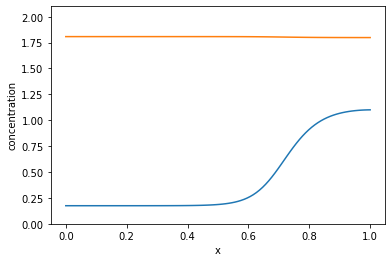

In [ ]:
pyplot.ylim((0., 2.1))
pyplot.xlabel('x'); pyplot.ylabel('concentration')
pyplot.plot(x_grid, U)
pyplot.plot(x_grid, V)
pyplot.show()

Aqui temos um [quimógrafo](http://en.wikipedia.org/wiki/Kymograph) dos valores de `U`.
Este gráfico mostra concisamente o comportamento de `U` no tempo e podemos claramente observar o comportamento de estabilização da onda descrito por [Mori *et al.*](http://www.sciencedirect.com/science/article/pii/S0006349508704442).
Além disso, observamos que esse padrão de onda é estável por cerca de 50 unidades de tempo e podemos concluir que o padrão é o estado estacionário do nosso sistema.

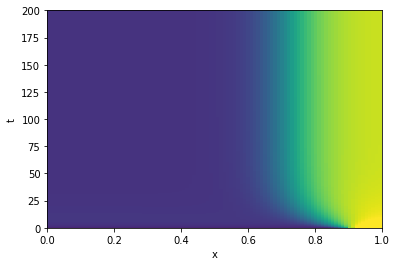

In [ ]:
U_record = numpy.array(U_record)
V_record = numpy.array(V_record)

fig, ax = pyplot.subplots()
pyplot.xlabel('x'); pyplot.ylabel('t')
heatmap = ax.pcolor(x_grid, t_grid, U_record, vmin=0., vmax=1.2)